## Setup

In this notebook we analyze the different categories of flaky job failures identified, based on frequent, cost, time evolution. 

In [1]:
import importlib
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from src.utils import vizualization as viz
from src.utils import utils


importlib.invalidate_caches()
importlib.reload(viz)
importlib.reload(utils)

<module 'src.utils.utils' from '/home/henri/Documents/ETS/telus-intermittent-failures/src/utils/utils.py'>

In [2]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'noise_dist',
    'scale': 3
  }
}

In [3]:
df = pd.read_csv("../../data/labeled_intermittent_failures.csv")
df.head(5)

,id,failure_reason,project,log,created_at,started_at,duration,queued_duration,group,category
0,24005,unknown_failure,44,[0KRunning with gitlab-ci-multi-runner 9.5.0 ...,2018-11-20 22:41:35.163000+00:00,2018-11-20 22:41:51.894000+00:00,1.076317,16.652029,dependency_issues,os_cmd_execution_error
1,24006,unknown_failure,44,[0KRunning with gitlab-ci-multi-runner 9.5.0 ...,2018-11-20 22:42:59.632000+00:00,2018-11-20 22:43:57.591000+00:00,0.511468,57.912983,dependency_issues,os_cmd_execution_error
2,130600,script_failure,44,[0KRunning with gitlab-runner 14.1.0 (8925d9a...,2021-09-19 20:21:49.019000+00:00,2021-09-19 20:22:05.772000+00:00,25.153492,16.458085,environment_variables,environment_variable_misconfigured
3,102411,runner_system_failure,44,[0KRunning with gitlab-runner 12.9.0 (4c96e5a...,2021-03-19 17:33:47.934000+00:00,2021-03-19 17:33:48.916000+00:00,368.338902,0.956225,limits_exceeded,runner_pod_waiting_timeout
4,102426,runner_system_failure,44,[0KRunning with gitlab-runner 12.9.0 (4c96e5a...,2021-03-19 18:02:43.204000+00:00,2021-03-19 18:02:45.420000+00:00,64.386497,2.173194,limits_exceeded,remote_call_timeout


In [4]:
df.shape[0]

4511

## Analysis of Frequency

In [6]:
category_losses = df['category'].value_counts().reset_index()
category_losses.columns = ['category', 'frequency']
category_losses.head(5)

,category,frequency
0,misconfigured_env_variable,673
1,docker_daemon_connection_failure,325
2,container_platform_auth_failure,314
3,job_execution_timeout,306
4,image_not_found,221


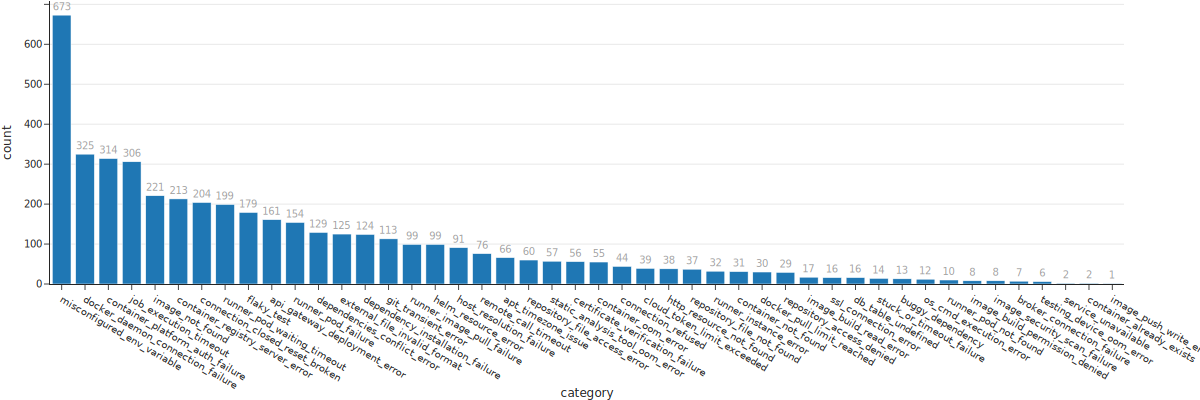

In [7]:
df_copy = df.copy(deep=True)
viz.plot_categories(df_copy, col="category", config=config)

In [8]:
categories = df.groupby(['group', 'category']).agg({'id': ['count', lambda x: round(len(x)*100/df.shape[0], 2)], 'project':lambda x: x.nunique()})
categories = categories.reset_index()
categories.columns = ['group', 'category', 'count', '%', 'count_affected_projects']
categories.head(10)

,group,category,count,%,count_affected_projects
0,container_issues,container_already_exists,2,0.04,1
1,container_issues,container_not_found,31,0.69,7
2,container_issues,docker_daemon_connection_failure,325,7.20,13
3,container_issues,image_build_permission_denied,8,0.18,1
4,container_issues,image_build_read_error,17,0.38,5
5,container_issues,image_push_write_error,1,0.02,1
6,container_issues,image_security_scan_failure,8,0.18,7
7,database_issues,db_table_undefined,16,0.35,1
8,dependency_issues,buggy_dependency,13,0.29,4
9,dependency_issues,dependencies_conflict_error,129,2.86,4


What are the top 5 categories?

In [9]:
top5 = categories.sort_values(by='count', ascending=False).head(5)
top5

,group,category,count,%,count_affected_projects
11,environment_variables,misconfigured_env_variable,673,14.92,35
2,container_issues,docker_daemon_connection_failure,325,7.20,13
44,unauthorized_access,container_platform_auth_failure,314,6.96,34
24,limits_exceeded,job_execution_timeout,306,6.78,19
40,remote_resource_errors,image_not_found,221,4.90,25


How many projects are impacted by the top 5 most frequent failure categories?

In [10]:
len(df[df['category'].isin(top5['category'])]['project'].unique())

59

In [11]:
categories.to_csv("../results/categories.csv", index=False)

In [12]:
categories['count'].sum()

np.int64(4511)

## Analysis of Costs

### Machine Cost

In [13]:
df.shape

(4511, 10)

In [14]:
df[['duration']].describe()

,duration
count,4511.000000
mean,255.276612
std,645.341544
min,0.511468
25%,21.334280
50%,46.896091
75%,188.145879
max,5919.227682


In [15]:
utils.seconds_to_human_readable(df['duration'].max())

'1.0 hour, 38.0 minutes, 39.0 seconds'

In [16]:
M = 0.14 # is the machine pricing rate in $/min

machine_cost = (
    df[["category", "duration"]]
    .groupby("category")
    .agg("sum")
    .reset_index()
)
machine_cost.columns = ["category", "duration"]
machine_cost["machine_cost"] = (machine_cost["duration"] / 60) * M # by default duration is in seconds 
machine_cost.sort_values("machine_cost", ascending=False).head(10)

,category,duration,machine_cost
29,job_execution_timeout,557382.185981,1300.558434
19,flaky_test,84131.229182,196.306201
44,stuck_or_timeout_failure,67342.808605,157.133220
14,dependencies_conflict_error,63284.134284,147.662980
12,container_registry_server_error,53592.016130,125.048038
40,runner_pod_waiting_timeout,38654.977596,90.194948
11,container_platform_auth_failure,25218.399252,58.842932
6,connection_closed_reset_broken,24996.820562,58.325915
38,runner_pod_failure,22815.082833,53.235193
26,image_not_found,22558.578138,52.636682


In [17]:
categories = (
    categories.set_index("category")
    .join(machine_cost[["category", "machine_cost"]].set_index("category"))
    .reset_index()
)
categories["machine_cost"] = categories["machine_cost"].apply(lambda x: round(x, 2))
categories.head(5)

,category,group,count,%,count_affected_projects,machine_cost
0,container_already_exists,container_issues,2,0.04,1,0.90
1,container_not_found,container_issues,31,0.69,7,17.88
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09
3,image_build_permission_denied,container_issues,8,0.18,1,0.75
4,image_build_read_error,container_issues,17,0.38,5,27.67


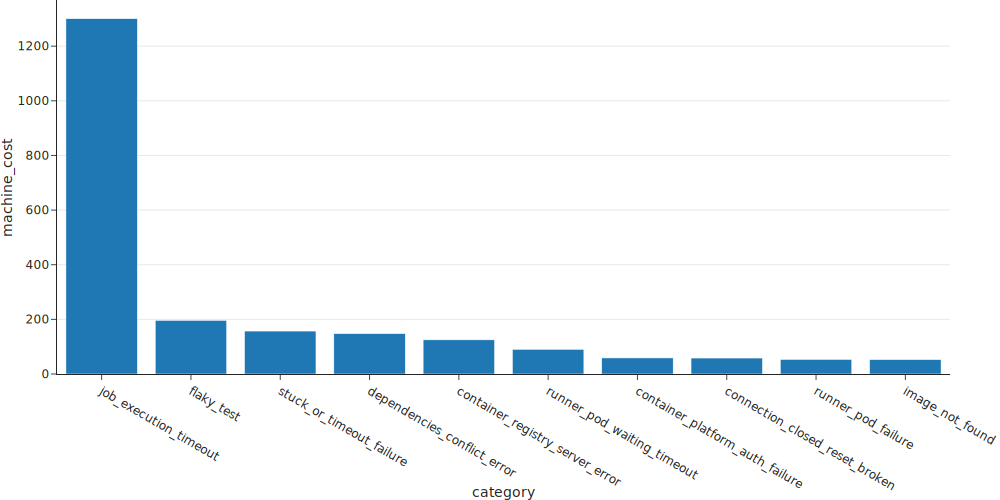

In [18]:
fig = px.bar(categories.sort_values("machine_cost", ascending=False).head(10), x="category", y="machine_cost", template="simple_white")
fig.update_layout(
    font_family="Rockwell",
    font_size=12,
    autosize=True,
    margin=dict(l=50, r=50, b=0, t=0, pad=0),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.95),
    width=1000
)
fig.update_yaxes(showgrid=True,)
fig.update_traces(textangle=0, textposition="outside", textfont_color="#a2a2a2", cliponaxis=False)
fig.show(renderer="svg", config=config)

### Diagnosis Cost

In [19]:
jobs = pd.read_csv("../../data/jobs.csv")

# correct invalid values
jobs["created_at"] = pd.to_datetime(jobs["created_at"], format="mixed", utc=True)
jobs["finished_at"] = pd.to_datetime(jobs["finished_at"], format="mixed", utc=True)

Get rerun suites

In [20]:
grouped_jobs = (
    jobs[jobs["status"].isin(["success", "failed"])]
    .sort_values(by=["created_at"], ascending=True)
    .groupby(["project", "commit", "name"])
    .aggregate(
        {
            "id": list,
            "status": list,
            "created_at": list,
            "finished_at": list,
        }
    )
).reset_index()

grouped_jobs["count"] = grouped_jobs["id"].apply(lambda x: len(x))
flaky_reruns = grouped_jobs[
    grouped_jobs["status"].map(lambda x: set(["success", "failed"]).issubset(x))
].reset_index(drop=True)
flaky_reruns

,project,commit,name,id,status,created_at,finished_at,count
0,44,025ee09bab30d3783a43423edf1b50121f2233ac,unit test,"[24005, 24006, 24007, 24539, 24542]","[failed, failed, success, success, success]","[2018-11-20 22:41:35.163000+00:00, 2018-11-20 ...","[2018-11-20 22:41:52.970000+00:00, 2018-11-20 ...",5
1,44,087ad82826025665dc68c458bef25a2fe235b409,trigger_build_deploy,"[148627, 158792]","[success, failed]","[2021-12-15 04:48:18.023000+00:00, 2022-02-24 ...","[2021-12-15 04:48:55.061000+00:00, 2022-02-24 ...",2
2,44,09392dc315d81f8a0de8c76ebed67231546ff53f,trigger_build_deploy,"[93604, 102394]","[success, failed]","[2021-02-05 01:48:54.372000+00:00, 2021-03-19 ...","[2021-02-05 01:50:01.194000+00:00, 2021-03-19 ...",2
3,44,1236dc012aa3c70c53d4dcb7c2d34d59647e3722,trigger_build_deploy,"[258172, 258184, 258185, 258196, 258197, 258204]","[failed, failed, failed, failed, failed, success]","[2023-02-13 15:57:02.507000+00:00, 2023-02-13 ...","[2023-02-13 15:58:59.570000+00:00, 2023-02-13 ...",6
4,44,1ba9dc3ad7f40f3a49e09b6f1b077ee2c9423a4a,trigger_infra_deploy,"[164120, 164122]","[failed, success]","[2022-03-18 21:05:02.719000+00:00, 2022-03-18 ...","[2022-03-18 21:05:50.081000+00:00, 2022-03-18 ...",2
...,...,...,...,...,...,...,...,...
3857,1374,fc7c072035e22a9521fb6461f6df1e08442c8ba9,deploy,"[408284, 408286, 408288, 408290, 408295, 40836...","[success, success, failed, success, success, s...","[2024-02-28 23:42:46.171000+00:00, 2024-02-28 ...","[2024-02-28 23:45:20.855000+00:00, 2024-02-28 ...",9
3858,1374,fccb5e21f54fab021f59736adfa67f4195375fd9,deploy,"[447161, 447164, 447165, 447168, 447173, 447178]","[success, failed, failed, failed, success, suc...","[2024-05-28 10:45:39.927000+00:00, 2024-05-28 ...","[2024-05-28 10:48:12.631000+00:00, 2024-05-28 ...",6
3859,1374,ff5c77f1a5b68b7aef66afdfccc37e26910c8255,deploy,"[449990, 449991]","[failed, success]","[2024-06-02 13:13:38.212000+00:00, 2024-06-02 ...","[2024-06-02 13:14:36.080000+00:00, 2024-06-02 ...",2
3860,1374,ff895581b7531df2e4ad09aebb9db318c660496c,deploy,"[406186, 406187, 406188]","[success, failed, success]","[2024-02-23 22:45:21.707000+00:00, 2024-02-23 ...","[2024-02-23 22:48:00.499000+00:00, 2024-02-23 ...",3


In [21]:
flaky_reruns["count"].sum()

np.int64(16378)

In [22]:
df_copy = df_copy.set_index("id")

In [23]:
def first_failure_finition_date(row):
    for i, status in enumerate(row["status"]):
        if status == "failed":
            return row["finished_at"][i]


def last_finition_date(row):
    return max(row["finished_at"])


def first_failure_category(row):
    for i, status in enumerate(row["status"]):
        if status == "failed":
            job_id = row["id"][i]
            if job_id in df["id"].to_list():
                return df_copy.loc[job_id, "category"]
            return None

In [24]:
flaky_reruns["category"] = flaky_reruns.apply(first_failure_category, axis=1)
flaky_reruns["first_failure_finished_at"] = flaky_reruns.apply(
    first_failure_finition_date, axis=1
)
flaky_reruns["last_job_finished_at"] = flaky_reruns.apply(last_finition_date, axis=1)
flaky_reruns = flaky_reruns[~flaky_reruns["category"].isnull()]
flaky_reruns["delay"] = (
    flaky_reruns["last_job_finished_at"] - flaky_reruns["first_failure_finished_at"]
)
flaky_reruns.head(1)

/tmp/ipykernel_30433/1111991219.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,project,commit,name,id,status,created_at,finished_at,count,category,first_failure_finished_at,last_job_finished_at,delay
0,44,025ee09bab30d3783a43423edf1b50121f2233ac,unit test,"[24005, 24006, 24007, 24539, 24542]","[failed, failed, success, success, success]","[2018-11-20 22:41:35.163000+00:00, 2018-11-20 ...","[2018-11-20 22:41:52.970000+00:00, 2018-11-20 ...",5,os_cmd_execution_error,2018-11-20 22:41:52.970000+00:00,2018-11-27 18:38:18.427000+00:00,6 days 19:56:25.457000


In [25]:
S = 0.6 # salary in $/min

diagnosis_cost = flaky_reruns[['category', 'delay']].groupby('category').sum().reset_index()
diagnosis_cost['delay_min'] = diagnosis_cost['delay'].apply(lambda x: x.total_seconds()/60) # convert delay in minutes
diagnosis_cost['diagnosis_cost'] = diagnosis_cost['delay_min'] * S
diagnosis_cost.sort_values('diagnosis_cost', ascending=False).head(10)

,category,delay,delay_min,diagnosis_cost
29,misconfigured_env_variable,514 days 15:30:01.204000,741090.020067,444654.01204
28,job_execution_timeout,460 days 23:13:44.068000,663793.734467,398276.24068
6,connection_closed_reset_broken,277 days 14:19:12.428000,399739.207133,239843.52428
15,dependency_installation_failure,262 days 23:28:37.178000,378688.619633,227213.17178
12,container_registry_server_error,228 days 16:09:08.255000,329289.137583,197573.48255
0,api_gateway_deployment_error,225 days 04:53:27.027000,324293.450450,194576.07027
25,image_build_read_error,177 days 20:08:27.295000,256088.454917,153653.07295
16,docker_daemon_connection_failure,169 days 16:46:01.134000,244366.018900,146619.61134
43,stuck_or_timeout_failure,161 days 06:49:39.597000,232249.659950,139349.79597
20,git_transient_error,147 days 17:57:45.106000,212757.751767,127654.65106


In [26]:
categories = (
    categories.set_index("category")
    .join(diagnosis_cost[["category", "diagnosis_cost"]].set_index("category"))
    .reset_index()
)
categories["diagnosis_cost"] = categories["diagnosis_cost"].apply(lambda x: round(x, 2))
categories["diagnosis_cost"] = categories["diagnosis_cost"].fillna(0)
categories.head(10)

,category,group,count,%,count_affected_projects,machine_cost,diagnosis_cost
0,container_already_exists,container_issues,2,0.04,1,0.90,0.54
1,container_not_found,container_issues,31,0.69,7,17.88,19686.51
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09,146619.61
3,image_build_permission_denied,container_issues,8,0.18,1,0.75,700.84
4,image_build_read_error,container_issues,17,0.38,5,27.67,153653.07
5,image_push_write_error,container_issues,1,0.02,1,0.12,0.00
6,image_security_scan_failure,container_issues,8,0.18,7,8.57,56.84
7,db_table_undefined,database_issues,16,0.35,1,1.71,11766.12
8,buggy_dependency,dependency_issues,13,0.29,4,5.30,7776.07
9,dependencies_conflict_error,dependency_issues,129,2.86,4,147.66,47063.55


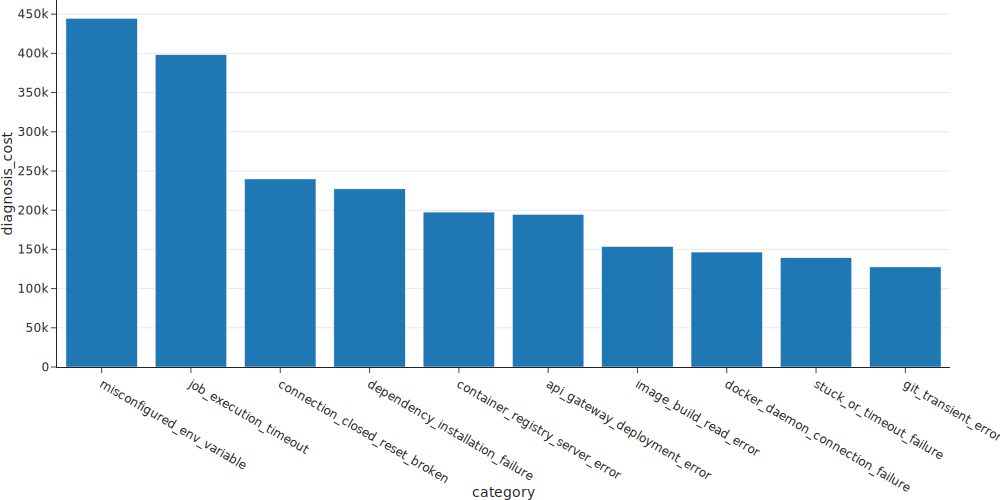

In [27]:
fig = px.bar(categories.sort_values("diagnosis_cost", ascending=False).head(10), x="category", y="diagnosis_cost", template="simple_white")
fig.update_layout(
    font_family="Rockwell",
    font_size=12,
    autosize=True,
    margin=dict(l=50, r=50, b=0, t=0, pad=0),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.95),
    width=1000
)
fig.update_yaxes(showgrid=True,)
fig.update_traces(textangle=0, textposition="outside", textfont_color="#a2a2a2", cliponaxis=False)
fig.show(renderer="svg", config=config)

### Total Cost

In [28]:
categories['cost'] = categories['machine_cost'] + categories['diagnosis_cost']

In [29]:
categories

,category,group,count,%,count_affected_projects,machine_cost,diagnosis_cost,cost
0,container_already_exists,container_issues,2,0.04,1,0.90,0.54,1.44
1,container_not_found,container_issues,31,0.69,7,17.88,19686.51,19704.39
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09,146619.61,146640.70
3,image_build_permission_denied,container_issues,8,0.18,1,0.75,700.84,701.59
4,image_build_read_error,container_issues,17,0.38,5,27.67,153653.07,153680.74
5,image_push_write_error,container_issues,1,0.02,1,0.12,0.00,0.12
6,image_security_scan_failure,container_issues,8,0.18,7,8.57,56.84,65.41
7,db_table_undefined,database_issues,16,0.35,1,1.71,11766.12,11767.83
8,buggy_dependency,dependency_issues,13,0.29,4,5.30,7776.07,7781.37
9,dependencies_conflict_error,dependency_issues,129,2.86,4,147.66,47063.55,47211.21


In [30]:
categories.drop_duplicates(inplace=True)

In [31]:
categories['cost_rounded'] = categories['cost'].round()

In [32]:
plot_data = (
    categories.sort_values("cost", ascending=False)
    .head(20)
    .sort_values("cost")[["category", "cost", "machine_cost", "diagnosis_cost"]]
)
plot_data

,category,cost,machine_cost,diagnosis_cost
14,runner_image_pull_failure,36874.11,7.50,36866.61
22,cloud_token_limit_exceeded,44201.62,8.08,44193.54
9,dependencies_conflict_error,47211.21,147.66,47063.55
12,flaky_test,52484.30,196.31,52287.99
15,runner_instance_error,54727.46,1.36,54726.10
44,container_platform_auth_failure,76229.43,58.84,76170.59
40,image_not_found,81621.73,52.64,81569.09
16,runner_pod_failure,93746.23,53.24,93692.99
26,runner_pod_waiting_timeout,104502.56,90.19,104412.37
33,connection_refused,124047.15,10.37,124036.78


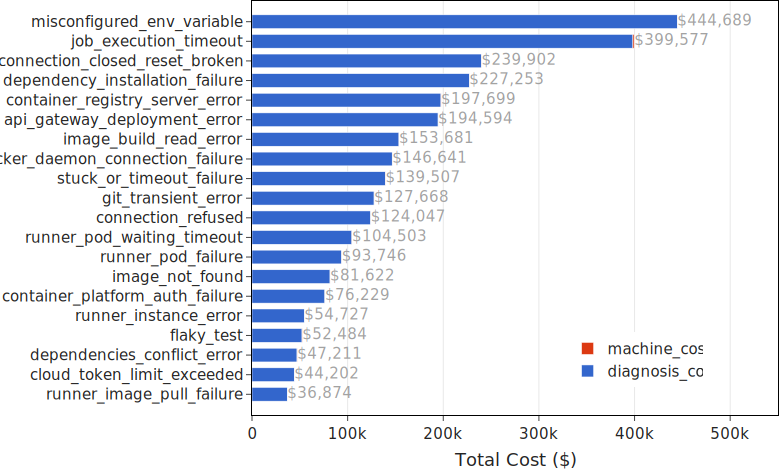

In [33]:
plot_data = categories.sort_values("cost", ascending=False).head(20).sort_values("cost")
fig = px.bar(
    plot_data,
    y="category",
    x=["diagnosis_cost", "machine_cost"],
    template="simple_white",
    labels={
        "variable": "",
        "value": "Total Cost ($)",
        "category": "",
        "diagnosis_cost": "Diagnosis Cost",
        "machine_cost": "Machine Cost",
    },
    color_discrete_sequence=[
        px.colors.qualitative.G10[0],
        px.colors.qualitative.G10[1],
    ],
    orientation="h",
)
fig.update_traces(width=0.7)

fig.add_trace(
    go.Scatter(
        y=plot_data["category"],
        x=plot_data["cost_rounded"],
        text=(plot_data["cost_rounded"]).map("  ${:,.0f}".format),
        mode="text",
        textposition="middle right",
        textfont=dict(size=15, color="#a2a2a2"),
        showlegend=False,
    )
)

fig.update_layout(
    font_family="Rockwell",
    font_size=15,
    autosize=True,
    margin=dict(l=0, r=2, b=0, t=1, pad=0),
    legend=dict(yanchor="top", y=0.2, xanchor="left", x=0.6, traceorder="reversed"),
    width=780,
    height=470,
)

fig.update_xaxes(
    showline=True,
    showgrid=True,
    linewidth=1,
    range=[0, 550000],
    linecolor="black",
    mirror=True,
    ticks="outside",
)
fig.update_yaxes(
    showline=True,
    showgrid=False,
    linewidth=0,
    linecolor="black",
    mirror=True,
    showticklabels=True,
)
"""
fig.update_traces(
    textangle=0, textposition="outside", textfont_color="#a2a2a2", cliponaxis=False, width=.7
)
"""
fig.show(renderer="svg", config=config)

In [34]:
categories.drop(columns=["cost_rounded"], inplace=True)
categories.head(3)

,category,group,count,%,count_affected_projects,machine_cost,diagnosis_cost,cost
0,container_already_exists,container_issues,2,0.04,1,0.90,0.54,1.44
1,container_not_found,container_issues,31,0.69,7,17.88,19686.51,19704.39
2,docker_daemon_connection_failure,container_issues,325,7.20,13,21.09,146619.61,146640.70


In [35]:
categories['diagnosis_cost_proportion'] = (categories['diagnosis_cost'] * 100 / categories['cost']).apply(lambda x: round(x, 2))

In [36]:
top20_costly = categories.sort_values('cost', ascending=False).head(20)
top20_costly.loc[top20_costly['diagnosis_cost_proportion'].idxmin(), :]

category                     flaky_test
group                        flaky_test
count                               179
%                                  3.97
count_affected_projects              11
machine_cost                     196.31
diagnosis_cost                 52287.99
cost                            52484.3
diagnosis_cost_proportion         99.63
Name: 12, dtype: object

In [37]:
top20_costly.loc[top20_costly['diagnosis_cost_proportion'].idxmax(), :]

category                     runner_instance_error
group                        infrastructure_issues
count                                           32
%                                             0.71
count_affected_projects                          8
machine_cost                                  1.36
diagnosis_cost                             54726.1
cost                                      54727.46
diagnosis_cost_proportion                    100.0
Name: 15, dtype: object

In [38]:
categories.to_csv("../results/categories.csv", index=False)

## Analysis of Evolution in Time (Trends)

In [39]:
df

,id,failure_reason,project,log,created_at,started_at,duration,queued_duration,group,category
0,24005,unknown_failure,44,[0KRunning with gitlab-ci-multi-runner 9.5.0 ...,2018-11-20 22:41:35.163000+00:00,2018-11-20 22:41:51.894000+00:00,1.076317,16.652029,internal_os_issues,os_cmd_execution_error
1,24006,unknown_failure,44,[0KRunning with gitlab-ci-multi-runner 9.5.0 ...,2018-11-20 22:42:59.632000+00:00,2018-11-20 22:43:57.591000+00:00,0.511468,57.912983,internal_os_issues,os_cmd_execution_error
2,130600,script_failure,44,[0KRunning with gitlab-runner 14.1.0 (8925d9a...,2021-09-19 20:21:49.019000+00:00,2021-09-19 20:22:05.772000+00:00,25.153492,16.458085,environment_variables,misconfigured_env_variable
3,102411,runner_system_failure,44,[0KRunning with gitlab-runner 12.9.0 (4c96e5a...,2021-03-19 17:33:47.934000+00:00,2021-03-19 17:33:48.916000+00:00,368.338902,0.956225,limits_exceeded,runner_pod_waiting_timeout
4,102426,runner_system_failure,44,[0KRunning with gitlab-runner 12.9.0 (4c96e5a...,2021-03-19 18:02:43.204000+00:00,2021-03-19 18:02:45.420000+00:00,64.386497,2.173194,limits_exceeded,remote_call_timeout
...,...,...,...,...,...,...,...,...,...,...
4506,383137,script_failure,1374,[0KRunning with gitlab-runner 16.0.1 (7970408...,2024-01-12 12:58:53.312000+00:00,2024-01-12 12:59:14.249000+00:00,17.587356,20.076938,environment_variables,misconfigured_env_variable
4507,371060,script_failure,1374,[0KRunning with gitlab-runner 16.0.1 (7970408...,2023-12-13 02:03:35.310000+00:00,2023-12-13 02:04:02.484000+00:00,23.567838,26.514791,remote_resource_errors,external_file_invalid_format
4508,377466,script_failure,1374,[0KRunning with gitlab-runner 16.0.1 (7970408...,2023-12-29 07:05:57.361000+00:00,2023-12-29 07:06:03.058000+00:00,17.771522,4.951715,environment_variables,misconfigured_env_variable
4509,449990,script_failure,1374,[0KRunning with gitlab-runner 16.0.1 (7970408...,2024-06-02 13:13:38.212000+00:00,2024-06-02 13:14:27.662000+00:00,8.418553,48.464014,transient_vcs_errors,git_transient_error


We group the jobs by `category` and `created_at` to identify the number of jobs per day and by category

In [40]:
df_copy = df.copy(deep=True)
df_copy["created_at"] = pd.to_datetime(df_copy["created_at"], format="mixed", utc=True)
df_copy["date"] = df_copy["created_at"].apply(lambda t: t.to_pydatetime().date())
categories_trends = df_copy[["id", "date", "category"]].groupby(["date", "category"]).count().reset_index()
categories_trends.columns = ["date", "category", "count"]
categories_trends.head(5)

,date,category,count
0,2018-03-29,container_platform_auth_failure,3
1,2018-04-02,container_platform_auth_failure,1
2,2018-04-17,container_platform_auth_failure,1
3,2018-06-12,container_platform_auth_failure,2
4,2018-07-17,container_registry_server_error,1


We add the `empty_logs` category to better interpret the gaps

In [41]:
jobs = pd.read_csv("../../data/jobs.csv")
jobs["created_at"] = pd.to_datetime(jobs["created_at"], format="mixed", utc=True)
jobs["finished_at"] = pd.to_datetime(jobs["finished_at"], format="mixed", utc=True)

In [42]:
empty_logs = pd.read_csv("../../data/intermittent_failures.csv")
empty_logs = empty_logs[empty_logs['log'].isnull()]
empty_logs = empty_logs[["id", "log"]].set_index("id").join(jobs.set_index("id")).reset_index()[["id", "created_at", "log"]]
empty_logs

,id,created_at,log
0,158792,2022-02-24 23:03:15.727000+00:00,NaN
1,258172,2023-02-13 15:57:02.507000+00:00,NaN
2,258184,2023-02-13 16:19:18.121000+00:00,NaN
3,258185,2023-02-13 16:20:56.683000+00:00,NaN
4,258196,2023-02-13 16:34:29.329000+00:00,NaN
...,...,...,...
2502,263005,2023-03-06 10:43:18.722000+00:00,NaN
2503,263006,2023-03-06 10:43:18.734000+00:00,NaN
2504,291838,2023-05-23 12:14:41.732000+00:00,NaN
2505,292328,2023-05-24 09:45:29.421000+00:00,NaN


We select the `n` most frequent categories

In [43]:
n = 20

n_top_frequent_categories = (
    categories.sort_values("count", ascending=False).head(n)["category"].to_list()
)

We plot the evolution of the number of job over time by category

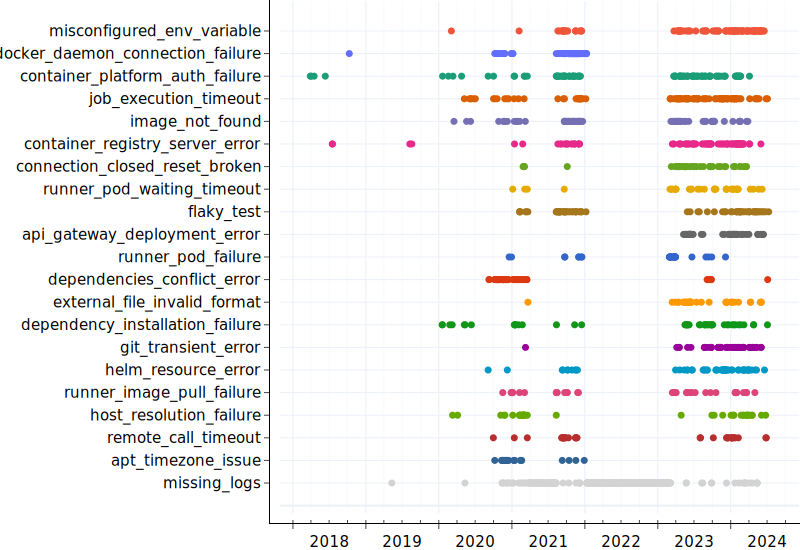

In [44]:
import importlib
from src.utils import vizualization as viz

importlib.invalidate_caches()
importlib.reload(viz)

data = [empty_logs] + [
    df[df["category"] == cat].copy() for cat in n_top_frequent_categories
][::-1]
titles = ["missing_logs"] + n_top_frequent_categories[::-1]
modes = ["markers"] * (n + 1)

colors = (
    ["#d3d3d3"]
    + px.colors.qualitative.G10_r
    + px.colors.qualitative.Dark2_r
    + px.colors.qualitative.Plotly * 3
)
start_date = "2018-02-01"
end_date = "2024-07-11"


def plot_count_timeseries(
    data: list[pd.DataFrame],
    titles: list[str],
    modes: list[str],
    colors: list[str],
    start_date: str,
    end_date: str,
    width: int = 1500,
    height: int = 300,
):
    """Plot count timeseries of dataframe on the same figure."""
    # add the figure traces
    plot_data = []
    y_values = []
    for i, df in enumerate(data):
        count_ts = viz.to_count_ts(df)
        count_ts["timestamp"] = pd.to_datetime(count_ts["date"])
        count_ts = count_ts[
            (count_ts["timestamp"] >= start_date) & (count_ts["timestamp"] <= end_date)
        ]
        y_values.append(i + 1)
        # add the time series as a line chart
        plot_data.append(
            go.Scatter(
                x=count_ts["date"],
                y=[i + 1] * count_ts.shape[0],
                mode=modes[i],
                marker=dict(size=7, color=colors[i]),
                line=dict(width=1, color=colors[i]),
                showlegend=True,
                name=titles[i],
                line_shape="spline",
                line_smoothing=0.3,
                # marker_symbol='line-ns-open',
            )
        )
    layout = go.Layout(
        font_family="Rockwell",
        font_size=15,
        font_color="black",
        autosize=False,
        margin=dict(l=280, r=1, b=0, t=1, pad=10),
        showlegend=False,
        legend=dict(
            xanchor="center",
            x=0.5,
            orientation="h",
            entrywidth=0.5,
            entrywidthmode="fraction",
            traceorder="reversed",
        ),
        width=width,
        height=height,
        template="plotly_white",
    )
    # show the figure
    fig = go.Figure(data=plot_data, layout=layout)
    fig.update_xaxes(
        showline=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="outside",
        ticklabelmode="period",
        minor=dict(ticks="inside", showgrid=True),
    )
    fig.update_yaxes(
        showline=True,
        showgrid=True,
        linewidth=1,
        linecolor="black",
        mirror=True,
        ticks="outside",
        showticklabels=True,
        tickmode="array",
        tickvals=y_values,
        ticktext=titles,
    )
    fig.show(renderer="svg", config=config)


plot_count_timeseries(
    data, titles, modes, colors, start_date, end_date, width=800, height=550  # 670, 450
)

In [45]:
categories.to_csv("../results/categories.csv", index=False)